# GPU gauge transformation

### Set parametres and eviroment variables

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2      
# N = 128   
N = 16 
tau_sim = 1     
DTS = 4     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

# TODO: Run more events
nevents = 1

- - -

In [2]:
import os

# I need to add this line to ask resources from a specific GPU, which is free. Our GPU server has no queing system
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
# import curraun.lc_gauge as lc_gauge
import curraun.lc_gauge_zindep as lc_gauge
# Gauge transformation for U_-
lc_gauge.LCDEBUG = True

Using CUDA
Using SU(3)
Using double precision


### We define the simulation routine

In [3]:
# import pickle
from tqdm import tqdm

# Simulation routine
def simulate(): 
    output = {}
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    #TODO: for testing only, remove after testing
    mv.set_seed(24)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)

    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize LC gauge transformation
    nplus = maxt//DTS
    lc = lc_gauge.LCGaugeTransf(s, nplus)

    # Plus gauge link
    # xplus=0 is not included
    uplus_lc = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N, su.GROUP_ELEMENTS)))

    if lc_gauge.LCDEBUG:
        # xplus=0 in not included
        # also, xplus=maxt is not included
        uminus_lc = su.GROUP_TYPE(np.zeros((maxt//DTS-2, N, su.GROUP_ELEMENTS)))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):            
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            if t%DTS == 0:
                for xplus in range(maxt//DTS):
                    lc.evolve_lc(xplus)
                    if xplus == (t//DTS) and xplus != 0:
                        uplus_lc[xplus-1] = lc.up_lc.copy()

                        if lc_gauge.LCDEBUG:
                            if xplus != (maxt//DTS-1):
                                uminus_lc[xplus-1] = lc.um_lc.copy()

            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()

    output["uplus_lc"] = uplus_lc
    output["nplus"] = nplus

    if lc.LCDEBUG:
        output["uminus_lc"] = uminus_lc

    return output

In [4]:
output = simulate()

100%|██████████| 32/32 [00:04<00:00,  6.68it/s]


In [5]:
uplus_lc = output["uplus_lc"]
nplus = output["nplus"]

if lc_gauge.LCDEBUG:
    uminus_lc = output["uminus_lc"]

In [6]:
uplus_lc.shape

(7, 16, 9)

--- 
Plots

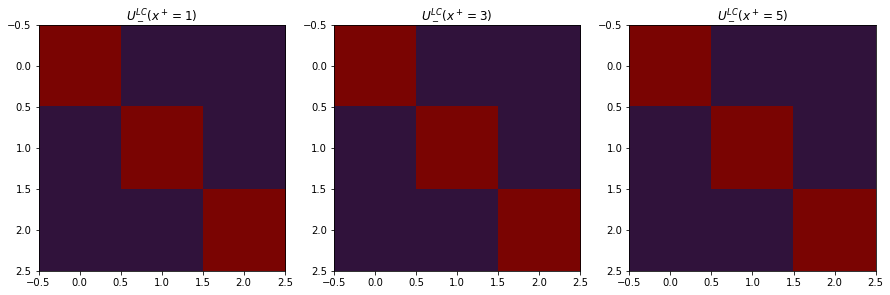

In [7]:
import matplotlib.pyplot as plt 

y = 0

fig_um, axs_um = plt.subplots(1, 3, figsize=(15,30))

for ixplus in range(nplus//3 + 1): 
    xplus = ixplus * 2 + 1
    
    uminuc_lc_color = uminus_lc[xplus, y, :].real.reshape(3,3)
    axs_um[ixplus].imshow(uminuc_lc_color, cmap='turbo', vmin=0, vmax=1) 
    axs_um[ixplus].set_title(r'$U_-^{LC}(x^+ = %i $)' %xplus)
    # plt.colorbar(plot1, ax = axs[t,0])

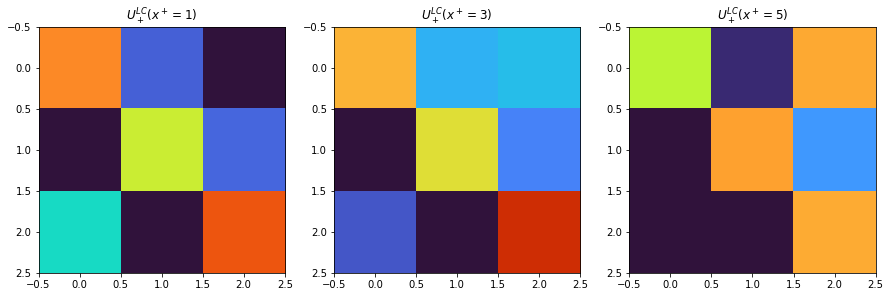

In [8]:
fig_up, axs_up = plt.subplots(1, 3, figsize=(15,30))

for ixplus in range(nplus//3 + 1): 
    xplus = ixplus * 2 + 1
    
    uplus_lc_color = uplus_lc[xplus, y, :].real.reshape(3,3)
    axs_up[ixplus].imshow(uplus_lc_color, cmap='turbo', vmin=0, vmax=1) 
    axs_up[ixplus].set_title(r'$U_+^{LC}(x^+ = %i $)' %xplus)
    # plt.colorbar(plot1, ax = axs[t,0])

- - -
### Comparison with the CPU version

In [2]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

# Don't print accuracy check 
import curraun.initial_su3 as initial_su3
initial_su3.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.lc_gauge_zindep as lc_gauge

# Number of colors
Nc = su.NC
# Dimension of algebra 
Dg = su.GROUP_ELEMENTS

Using Numba
Using SU(3)
Using double precision


In [3]:
# Supress various horribly long warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

     #TODO: for testing only, remove after testing
    mv.set_seed(24)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Plus gauge link
    uplus_LC = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N, Dg)))
    v_LC = su.GROUP_TYPE([[su.unit() for y in range(N)] for xplus in range (maxt//DTS)])

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):            
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Copy gauge links and gauge fields from the memory of the GPU
            if t%DTS == 0:
                u1 = s.u1.copy()
                u0 = s.u0.copy()
                
                ux_act = u1[:,0,:].reshape(N,N,Dg)
                ux_prev = u0[:,0,:].reshape(N,N,Dg)
   
                # We construct the u_+ links over the x^+ axis in a y transverse lattice
                uplus_temp = su.GROUP_TYPE(np.zeros((N,Dg)))
                
                for y in range(N):
                        uplus_temp[y] = lc_gauge.get_plus_links(ux_prev[t//DTS,y])                
                
                # We construct the gauge operator and transform the field
                for xplus in range(maxt//DTS):
                    for y in range(N):
                            
                            if xplus > (t//DTS): # We construct the gauge operator
                                v_prev = v_LC[xplus, y]
                                v_LC[xplus, y] = lc_gauge.gauge_transformation_operator(ux_act[2*xplus-t//DTS,y], v_prev)
                                
                            elif xplus == (t//DTS) and xplus != 0:
                                uplus_LC[xplus-1, y, :] = lc_gauge.act_on_links(uplus_temp[y], v_LC[xplus, y], v_LC[xplus-1, y])
                                
                
            
            
            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return uplus_LC

In [5]:
uplus_LC = simulate()

100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


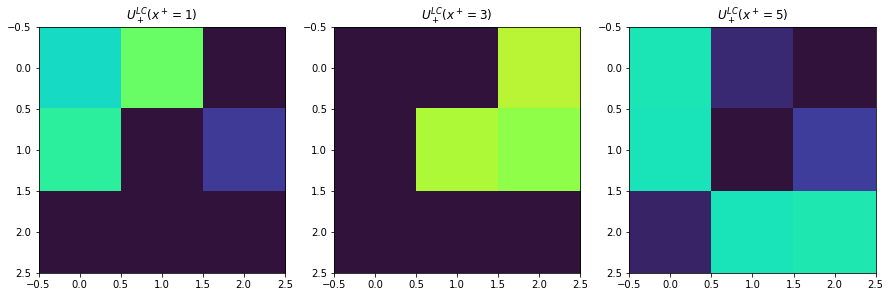

In [6]:
import matplotlib.pyplot as plt 

y = 0
nplus = uplus_LC.shape[0]

fig_up, axs_up = plt.subplots(1, 3, figsize=(15,30))

for ixplus in range(nplus//3 + 1): 
    xplus = ixplus * 2 + 1
    
    uplus_lc_color = uplus_LC[xplus, y, :].real.reshape(3,3)
    axs_up[ixplus].imshow(uplus_lc_color, cmap='turbo', vmin=0, vmax=1) 
    axs_up[ixplus].set_title(r'$U_+^{LC}(x^+ = %i $)' %xplus)
    # plt.colorbar(plot1, ax = axs[t,0])

---
Test lattice functions.

In [ ]:
Ny, Nxplus = N, N//2
# Test arrray
test = np.zeros(Ny*Nxplus)
for i in range(Ny-1):
    for j in range(Nxplus-1):
        test[i*Nxplus+j] = i*Nxplus+j

In [ ]:
def get_index_nm(ix, iy, n):
    return n * ix + iy
def get_point_nxm(x, n, m):
    r1 = x % n
    r0 = (x - r1) // m
    return r0, r1

In [ ]:
index = get_index_nm(3, 4, Ny)
index

196

In [ ]:
get_point_nxm(index, Nxplus, Ny)

(3, 4)